# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
# Import models you're considering
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


import json

with open("baseline_results.json", "r") as f:
    baseline_results = json.load(f)

mse_sarima  = baseline_results["mse_sarima"]
rmse_sarima = baseline_results["rmse_sarima"]
acc_sarima  = baseline_results["acc_sarima"]


## Model Selection

A Random Forest regression model is used due to its ability to capture non-linear relationships and complex interactions in atmospheric time series without requiring stationarity assumptions. Its robustness to noise and strong generalization performance make it suitable for monthly NAO prediction.


## Feature Engineering

Compared to the baseline model, which primarily used the raw NAO values and a simple winter flag, the Random Forest model incorporates additional engineered features to better capture temporal patterns and seasonality:

Lagged NAO values (1, 2, 3, 6, and 12 months) to represent short-term persistence, seasonal memory, and interannual variability.

Cyclical month encoding (sin and cos of month) to model the continuous seasonal cycle without artificial discontinuities between December and January.

Monthly climatology to provide the model with a baseline expectation of the NAO index for each calendar month.

These enhancements allow the model to leverage both historical values and seasonal context, improving its ability to forecast NAO beyond what the baseline features could capture.

In [19]:
# Load the NAO daily dataset
url = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
df = pd.read_csv(url)

# Clean and index time
df['time'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('time')

# Feature Engineering: Seasonality and Decades
# Winter (Nov-Apr) vs Summer (May-Oct)
winter_months = {11, 12, 1, 2, 3, 4}
df['season_flag'] = df['month'].apply(lambda m: 1 if m in winter_months else -1)
df['decade'] = df['year'] // 10 * 10

# Drop redundant columns
df.drop(columns=['day', 'year'], inplace=True)

# Convert to xarray for advanced climate data handling
ds = xr.Dataset.from_dataframe(df)

def fill_nans_weighted(ds, dim, n=3):
    """Fills NaNs using a weighted rolling mean (n neighbors)."""
    window = 2 * n + 1
    weights = np.ones(window) / window
    rolled = ds.rolling({dim: window}, center=True).construct("window")
    filled = (rolled * xr.DataArray(weights, dims=["window"])).sum("window")
    return ds.fillna(filled)

# Apply NaN filling
ds = fill_nans_weighted(ds, dim='time', n=3)

# Convert back to DataFrame
df = ds.to_dataframe()


# Feature Engineering

df_rf = df.copy()

# Create lagged NAO features for Random Forest
lags = [1, 2, 3, 6, 12]
for lag in lags:
    df_rf[f'lag_{lag}'] = df_rf['nao_index_cdas'].shift(lag)

# Cyclical month encoding to capture seasonality
df_rf['month_sin'] = np.sin(2 * np.pi * df_rf.index.month / 12)
df_rf['month_cos'] = np.cos(2 * np.pi * df_rf.index.month / 12)

# Monthly climatology feature
df_rf['climatology'] = df_rf.groupby(df_rf.index.month)['nao_index_cdas'].transform('mean')

# Drop rows with NaNs created by lagging
df_rf = df_rf.dropna()

In [20]:
df_rf = df_rf.dropna()
df_rf


,month,nao_index_cdas,season_flag,decade,lag_1,lag_2,lag_3,lag_6,lag_12,month_sin,month_cos,climatology
time,,,,,,,,,,,,
1950-01-13,1.0,0.477000,1.0,1950.0,0.314000,0.210000,-0.227000,-0.156000,0.365000,0.5,0.866025,0.07073
1950-01-14,1.0,0.733000,1.0,1950.0,0.477000,0.314000,0.210000,-0.440000,0.096000,0.5,0.866025,0.07073
1950-01-15,1.0,0.879000,1.0,1950.0,0.733000,0.477000,0.314000,-0.497000,-0.416000,0.5,0.866025,0.07073
1950-01-16,1.0,0.753000,1.0,1950.0,0.879000,0.733000,0.477000,-0.227000,-0.616000,0.5,0.866025,0.07073
1950-01-17,1.0,0.661000,1.0,1950.0,0.753000,0.879000,0.733000,0.210000,-0.261000,0.5,0.866025,0.07073
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-12,1.0,0.325179,1.0,2020.0,0.154792,-0.135593,-0.291468,-1.017777,-1.248607,0.5,0.866025,0.07073
2026-01-13,1.0,0.374379,1.0,2020.0,0.325179,0.154792,-0.135593,-0.546581,-0.879566,0.5,0.866025,0.07073
2026-01-14,1.0,0.448063,1.0,2020.0,0.374379,0.325179,0.154792,-0.395583,-1.119114,0.5,0.866025,0.07073


## Hyperparameter Tuning

For this Random Forest model, time-series-aware hyperparameter tuning was performed using a walk-forward validation approach. Different combinations of key parameters — including n_estimators, max_depth, min_samples_split, and min_samples_leaf — were evaluated by iteratively training on expanding historical data and validating on the next month. The combination that minimized the RMSE while maintaining stable ACC across folds was selected, ensuring the model generalizes well without leaking future information.


In [21]:

# HYPERPARAMETER TUNING 

features = ['lag_1','lag_2','lag_3','lag_6','lag_12',
            'month_sin','month_cos','climatology']
target = 'nao_index_cdas'

X = df_rf[features].values
y = df_rf[target].values

# Time-aware split
n_total = len(df_rf)
n_train = int(0.8 * n_total)

X_train, X_val = X[:n_train], X[n_train:]
y_train, y_val = y[:n_train], y[n_train:]

# Small grid (expand only if needed)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

print("Starting hyperparameter tuning...")

for idx, params in enumerate(ParameterGrid(param_grid)):
    model = RandomForestRegressor(
        **params,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mse = mean_squared_error(y_val, preds)

    print(
        f"Param set {idx+1}/{len(ParameterGrid(param_grid))} completed "
    )

print("Hyperparameter tuning completed.")


Starting hyperparameter tuning...
Param set 1/16 completed 
Param set 2/16 completed 
Param set 3/16 completed 
Param set 4/16 completed 
Param set 5/16 completed 
Param set 6/16 completed 
Param set 7/16 completed 
Param set 8/16 completed 
Param set 9/16 completed 
Param set 10/16 completed 
Param set 11/16 completed 
Param set 12/16 completed 
Param set 13/16 completed 
Param set 14/16 completed 
Param set 15/16 completed 
Param set 16/16 completed 
Hyperparameter tuning completed.


In [22]:
df_test_nao = df_rf.iloc[n_train:][['nao_index_cdas']]

df_test_nao

,nao_index_cdas
time,
2010-11-04,-0.302433
2010-11-05,-0.512983
2010-11-06,-0.202890
2010-11-07,0.097131
2010-11-08,-0.547629
...,...
2026-01-12,0.325179
2026-01-13,0.374379
2026-01-14,0.448063


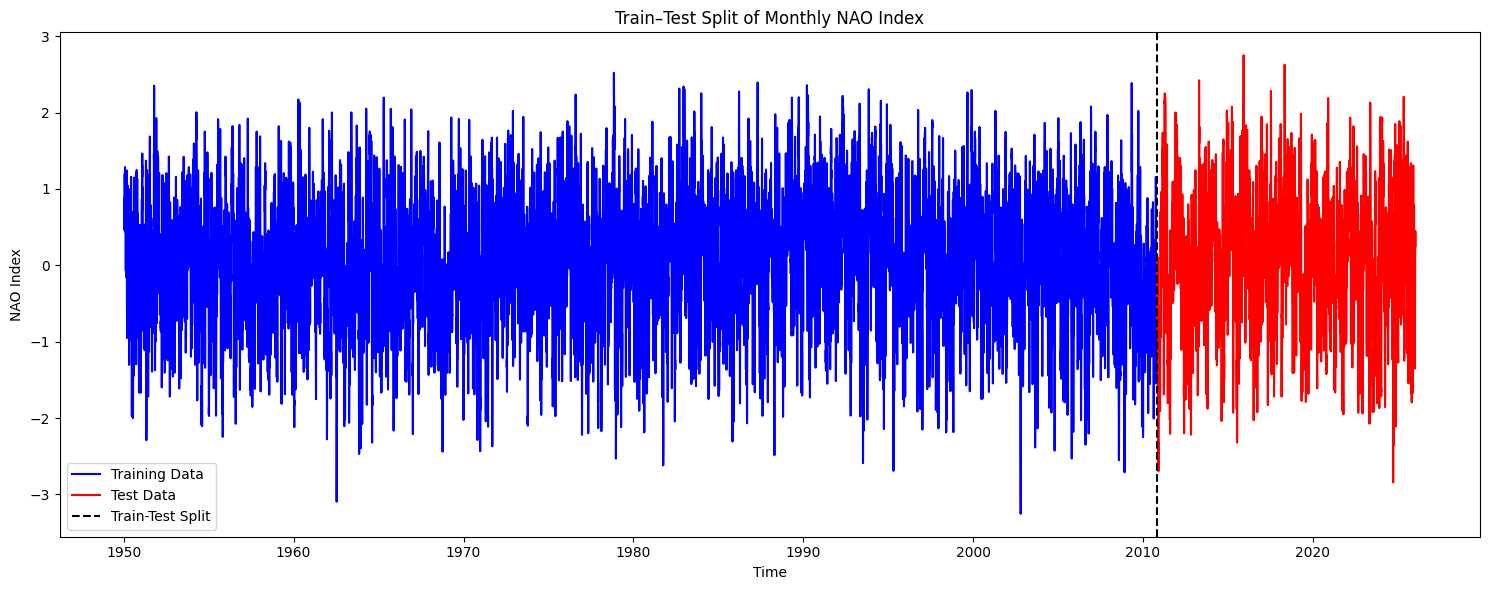

In [23]:
# TRAIN–TEST SPLIT VISUALIZATION

plt.figure(figsize=(15, 6))

# Training data
plt.plot(df_rf.index[:n_train], 
         df_rf['nao_index_cdas'][:n_train],
         label='Training Data',
         color='blue')

# Test data
plt.plot(df_rf.index[n_train:], 
         df_rf['nao_index_cdas'][n_train:],
         label='Test Data',
         color='red')

# Vertical split line
plt.axvline(df_rf.index[n_train], color='black', linestyle='--', label='Train-Test Split')

plt.title("Train–Test Split of Monthly NAO Index")
plt.ylabel("NAO Index")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [24]:

# FINAL RANDOM FOREST MODEL

features = ['lag_1','lag_2','lag_3','lag_6','lag_12',
            'month_sin','month_cos','climatology']
target = 'nao_index_cdas'

X = df_rf[features].values
y = df_rf[target].values

n_total = len(df_rf)
n_train = int(0.8 * n_total)

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train ONCE
rf_model.fit(X_train, y_train)

# Predict ALL test samples
predictions_rf = rf_model.predict(X_test)

print("Random Forest model training and prediction completed.")


Random Forest model training and prediction completed.


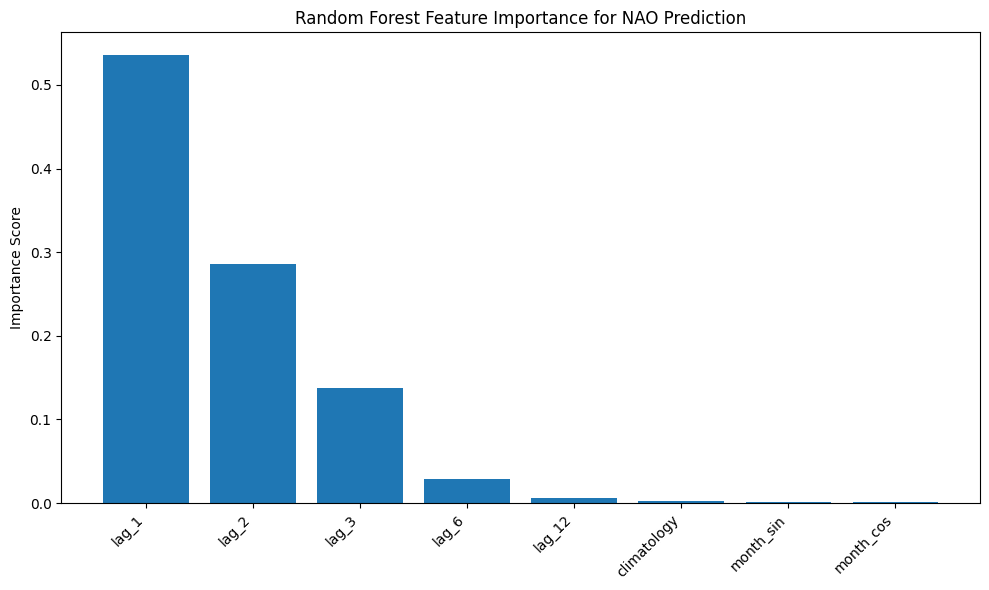

In [25]:
# FEATURE IMPORTANCE ANALYSIS (FIXED)

features_used = ['lag_1','lag_2','lag_3','lag_6','lag_12',
                 'month_sin','month_cos','climatology']

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(features_used)), importances[indices])

plt.xticks(range(len(features_used)),
           np.array(features_used)[indices],
           rotation=45, ha='right')

plt.title("Random Forest Feature Importance for NAO Prediction")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


## Evaluation Metrics

The model performance will be evaluated using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Anomaly Correlation Coefficient (ACC).

MSE: measures the average squared difference between predicted and observed values, emphasizing larger errors.

RMSE: provides the standard deviation of prediction errors, giving an interpretable measure of forecast accuracy.

ACC: assesses how well the model captures the temporal variability and anomalies of the NAO index relative to observations, making it a key metric in climate science.


In [26]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

# Example for regression
# mse = mean_squared_error(y_test, y_pred)

# Your evaluation code here

# EVALUATION METRICS

# Define Anomaly Correlation Coefficient (ACC)
def calculate_acc(obs, pred):
    return np.corrcoef(obs, pred)[0, 1]

# Random Forest metrics
mse_rf = mean_squared_error(y_test, predictions_rf)
rmse_rf = np.sqrt(mse_rf)
acc_rf = calculate_acc(y_test, predictions_rf)

print("RANDOM FOREST PERFORMANCE")
print(f"MSE  : {mse_rf:.4f}")
print(f"RMSE : {rmse_rf:.4f}")
print(f"ACC  : {acc_rf:.4f}")



RANDOM FOREST PERFORMANCE
MSE  : 0.0800
RMSE : 0.2828
ACC  : 0.9477


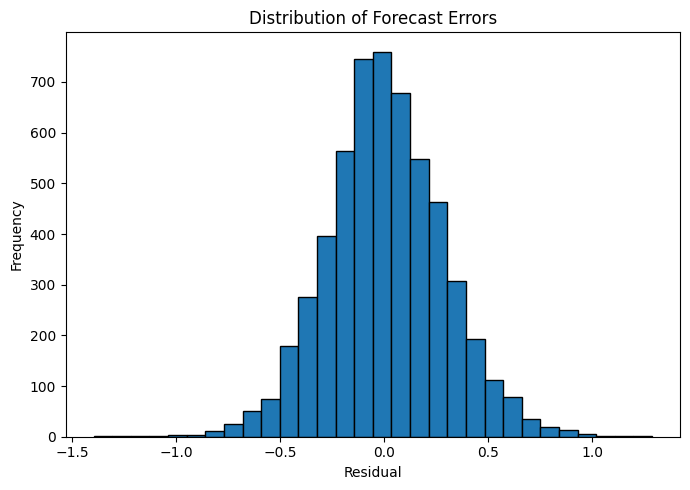

In [27]:
# RESIDUAL DIAGNOSTICS

residuals = y_test - predictions_rf

plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=30, edgecolor='black')

plt.title("Distribution of Forecast Errors")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


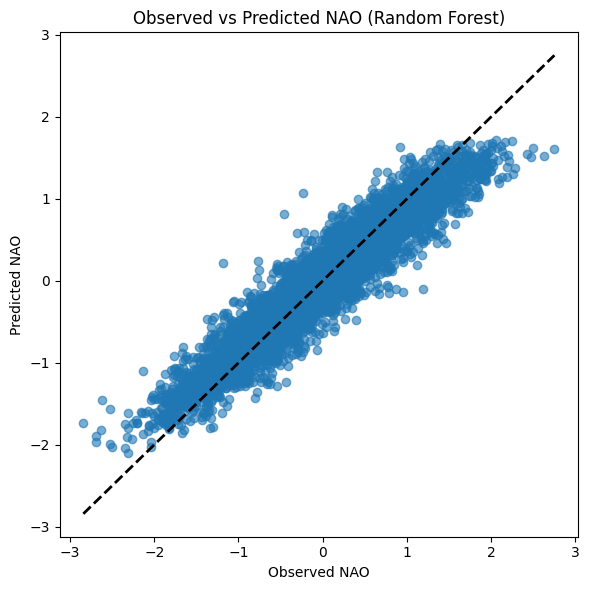

In [28]:
# SCATTER SKILL DIAGNOSTIC

plt.figure(figsize=(6, 6))

plt.scatter(y_test, predictions_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)

plt.xlabel("Observed NAO")
plt.ylabel("Predicted NAO")
plt.title("Observed vs Predicted NAO (Random Forest)")
plt.tight_layout()
plt.show()


In [29]:
# REGIME-BASED PERFORMANCE

positive_mask = y_test > 0
negative_mask = y_test <= 0

rmse_pos = np.sqrt(mean_squared_error(
    y_test[positive_mask], predictions_rf[positive_mask]))

rmse_neg = np.sqrt(mean_squared_error(
    y_test[negative_mask], predictions_rf[negative_mask]))

print("RMSE during Positive NAO:", rmse_pos)
print("RMSE during Negative NAO:", rmse_neg)


RMSE during Positive NAO: 0.28399787270324023
RMSE during Negative NAO: 0.2814884434209591


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [30]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")

# =============================
# BASELINE vs RANDOM FOREST COMPARISON
# =============================

print("\n" + "="*55)
print("        SARIMA BASELINE vs RANDOM FOREST MODEL")
print("="*55)

print(f"SARIMA MSE         : {mse_sarima:.4f}")
print(f"Random Forest MSE  : {mse_rf:.4f}\n")

print(f"SARIMA RMSE        : {rmse_sarima:.4f}")
print(f"Random Forest RMSE : {rmse_rf:.4f}\n")

print(f"SARIMA ACC         : {acc_sarima:.4f}")
print(f"Random Forest ACC  : {acc_rf:.4f}")

print("="*55)

mse_improvement  = ((mse_sarima - mse_rf) / mse_sarima) * 100
rmse_improvement = ((rmse_sarima - rmse_rf) / rmse_sarima) * 100
acc_improvement  = ((acc_rf - acc_sarima) / acc_sarima) * 100

print(f"MSE Improvement  : {mse_improvement:.2f}%")
print(f"RMSE Improvement : {rmse_improvement:.2f}%")
print(f"ACC Improvement  : {acc_improvement:.2f}%")
print("="*55)



        SARIMA BASELINE vs RANDOM FOREST MODEL
SARIMA MSE         : 0.2618
Random Forest MSE  : 0.0800

SARIMA RMSE        : 0.5117
Random Forest RMSE : 0.2828

SARIMA ACC         : 0.4327
Random Forest ACC  : 0.9477
MSE Improvement  : 69.44%
RMSE Improvement : 44.72%
ACC Improvement  : 119.04%


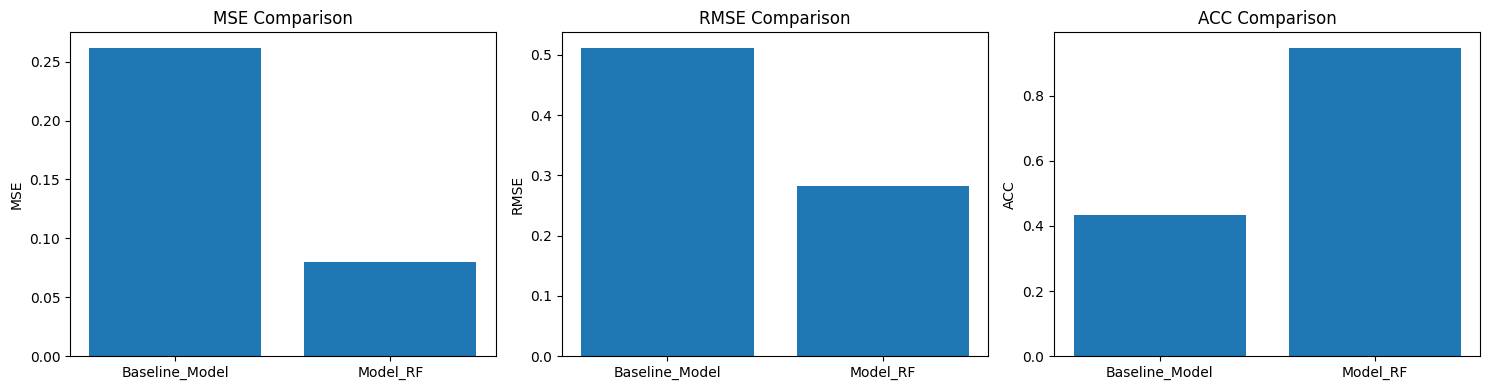

In [31]:
# VISUAL COMPARISON PLOTS

models = ['Baseline_Model', 'Model_RF']

mse_values  = [mse_sarima, mse_rf]
rmse_values = [rmse_sarima, rmse_rf]
acc_values  = [acc_sarima, acc_rf]

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.bar(models, mse_values)
plt.title("MSE Comparison")
plt.ylabel("MSE")

plt.subplot(1, 3, 2)
plt.bar(models, rmse_values)
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

plt.subplot(1, 3, 3)
plt.bar(models, acc_values)
plt.title("ACC Comparison")
plt.ylabel("ACC")

plt.tight_layout()
plt.show()
